### Supervisor Agent

In [2]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [75]:
from langgraph.graph import MessagesState,StateGraph,START, END
from langgraph.types import Command
from typing import Literal
from typing_extensions import TypedDict
from langgraph.prebuilt import create_react_agent

In [13]:
def route_request(
    state: MessagesState,
) -> Literal[
    "account_plan_team", "experience_generation_team", "general_conversation", "__end__"
]:
    """
    Inspects the user's request and routes it to the correct team.
    This function acts as a conditional edge.
    """
    print("--- Main Supervisor: Routing request ---")
    last_message = state["messages"][-1]
    content = last_message.content.lower()

    if "account plan" in content:
        print("--- Main Supervisor: Routing to Account Plan Team ---")
        return "account_plan_team"
    elif "visualize" in content or "experience" in content:
        print("--- Main Supervisor: Routing to Experience Generation Team ---")
        return "experience_generation_team"
    else:
        print(
            "--- Main Supervisor: No specific team keyword found. Handling general conversation. ---"
        )
        return "general_conversation"

In [31]:

def entry_point(state: MessagesState) -> dict:
    """
    A dummy entry point node. It doesn't do anything to the state,
    it just provides a starting point for the routing logic.
    """
    return {"messages": state["messages"]}

In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
search_tool.invoke("who is a current pm of uk?")

In [40]:
def account_plan_workflow(state: MessagesState) -> Command[Literal['__end__']]:
    """Get the account plan to the ticket"""
    print("--- Account Plan Team: Processing request ---")    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You have the latest information about everything.")
    result=research_agent.invoke(state)
    message_info = result["messages"][-1].content
    data = "Account plan is generated successfully for the message:"+ message_info.content
    return {"messages": data}

In [41]:
def experience_gen_workflow(state: MessagesState) -> Command[Literal['__end__']]:
    """Generate experience and visualizing the information"""
    print("--- Experience generation workflow processing request ---")
    message_info = state["messages"][-1]
    data = "Experience is generated successfully for the message:"+ message_info.content
    return {"messages": data}

In [ ]:
def general_conversation_agent(state: MessagesState) -> Command[Literal['__end__']]:
    """general conversation agent"""
    print("--- General conversation workflow processing request ---")
    message_info = state["messages"][-1]
    data = "General conversation is generated successfully for the message:"+ message_info.content
    return {"messages": data}

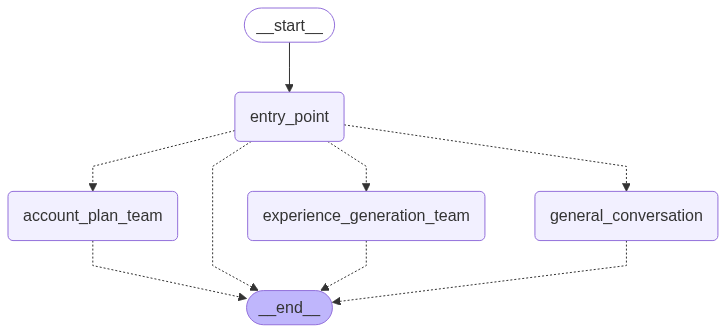

In [64]:
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)

builder.add_node("entry_point", entry_point)
builder.add_node(
    "account_plan_team", account_plan_workflow
)

builder.add_node(
    "experience_generation_team", experience_gen_workflow
)

# Add general conversation agent as a proper node
builder.add_node(
    "general_conversation", general_conversation_agent
)
builder.set_entry_point("entry_point")
# Define the routing logic from the entry point
builder.add_conditional_edges(
    "entry_point",
    route_request,
    {
        "account_plan_team": "account_plan_team",
        "experience_generation_team": "experience_generation_team",
        "general_conversation": "general_conversation",
        "__end__": END,
    },
)

# After a team has finished, the workflow ends.
builder.add_edge("account_plan_team", END)
builder.add_edge("experience_generation_team", END)
builder.add_edge("general_conversation", END)

# Add memory to the agent
memory = MemorySaver()

# Compile the supervisor graph
compiled_state_graph = builder.compile(checkpointer=memory)
compiled_state_graph

In [70]:
config={"configurable": {"thread_id": "1"}}

In [71]:
compiled_state_graph.invoke({"messages": "Visualize the monthly sales data as a bar chart"}, config=config)

--- Main Supervisor: Routing request ---
--- Main Supervisor: Routing to Experience Generation Team ---
--- Experience generation workflow processing request ---


{'messages': [HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='c7d2d65c-3d60-4335-83ae-ff684b4ccb63'),
  HumanMessage(content='Experience is generated successfully for the message:Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='d20b1f90-93a7-4b03-a541-3a4bf5816ee2'),
  HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='7128f14f-f110-4954-ae62-2be329b4bb67'),
  HumanMessage(content='Experience is generated successfully for the message:Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='8ad7c640-6983-4f36-b975-8ad4789dc730'),
  HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='7e46f9dc-aea5-4d4c-a009-71b673be9002'),
  HumanMessage(content='Experience is generated successfully for the mes

In [73]:
compiled_state_graph.invoke({"messages": "hi, how are you?"}, config=config)

--- Main Supervisor: Routing request ---
--- Main Supervisor: No specific team keyword found. Handling general conversation. ---
--- General conversation workflow processing request ---


{'messages': [HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='c7d2d65c-3d60-4335-83ae-ff684b4ccb63'),
  HumanMessage(content='Experience is generated successfully for the message:Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='d20b1f90-93a7-4b03-a541-3a4bf5816ee2'),
  HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='7128f14f-f110-4954-ae62-2be329b4bb67'),
  HumanMessage(content='Experience is generated successfully for the message:Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='8ad7c640-6983-4f36-b975-8ad4789dc730'),
  HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='7e46f9dc-aea5-4d4c-a009-71b673be9002'),
  HumanMessage(content='Experience is generated successfully for the mes

In [74]:
compiled_state_graph.invoke({"messages": "Account plan for apple"}, config=config)

--- Main Supervisor: Routing request ---
--- Main Supervisor: Routing to Account Plan Team ---
--- Account Plan Team: Processing request ---


{'messages': [HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='c7d2d65c-3d60-4335-83ae-ff684b4ccb63'),
  HumanMessage(content='Experience is generated successfully for the message:Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='d20b1f90-93a7-4b03-a541-3a4bf5816ee2'),
  HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='7128f14f-f110-4954-ae62-2be329b4bb67'),
  HumanMessage(content='Experience is generated successfully for the message:Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='8ad7c640-6983-4f36-b975-8ad4789dc730'),
  HumanMessage(content='Visualize the monthly sales data as a bar chart', additional_kwargs={}, response_metadata={}, id='7e46f9dc-aea5-4d4c-a009-71b673be9002'),
  HumanMessage(content='Experience is generated successfully for the mes